# **1. Data Process Categorical**
---

## **1.1 Imports**

In [1]:
import pandas as pd
import glob
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, cross_val_score, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import json
# import joblib
from sklearn.pipeline import Pipeline
from joblib import dump

c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **1.2 File imports**

In [2]:
# folder for txt files
folder = 'qws1_dataset/*.txt'

# list of files
files = glob.glob(folder)

# number of files
count = 1
for file in files:
    print(f'File number {count} - {file}')
    count += 1

File number 1 - qws1_dataset\qws1.txt


In [3]:
df_list = []

for file in files:
    try:
        # Detect header dynamically: find first line with commas
        with open(file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        header_line = None
        for i, line in enumerate(lines):
            if ',' in line:
                header_line = i
                break
        
        if header_line is None:
            print(f"Skipping {file}: No CSV content found")
            continue
        
        # Read from detected header line
        df = pd.read_csv(file, sep=',', skiprows=header_line)
        df_list.append(df)
    
    except Exception as e:
        print(f"Skipping {file}: {e}")

if df_list:
    df = pd.concat(df_list, ignore_index=True, sort=False)
else:
    print("No valid files")

## **1.3 Features check**

### **1.3.1 Heatmap**

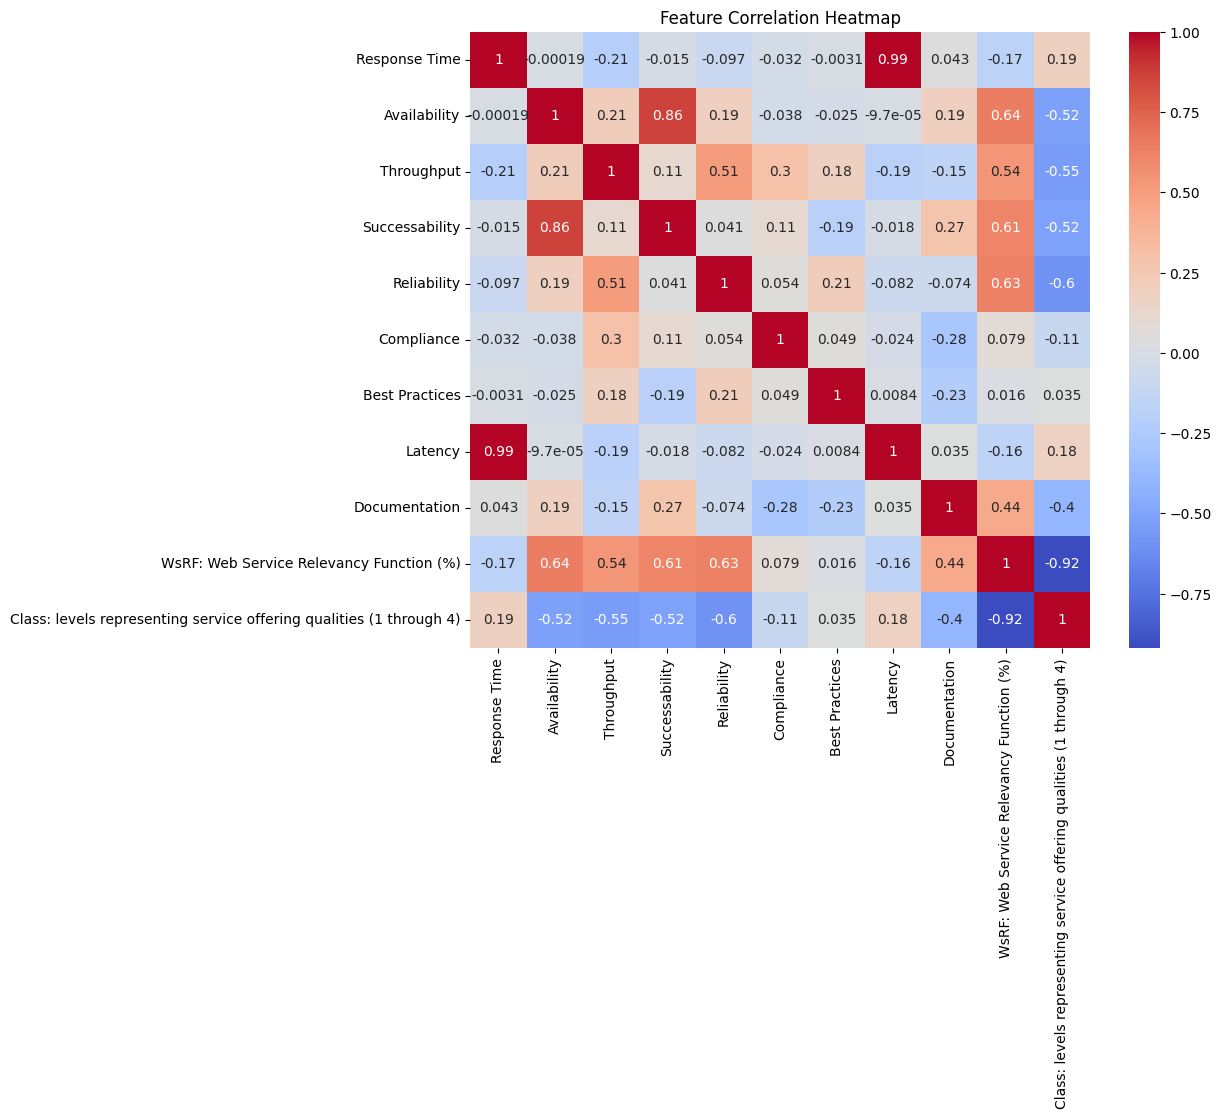

In [4]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

Dropping columns that dont add value to the model:
 - Service Name, WSDL Address, Class: levels representing service offering qualities (1 through 4) (target value), WsRF: Web Service Relevancy Function (%) (has negative correlation with target value)

In [5]:
df.dtypes

Response Time                                                          float64
Availability                                                             int64
Throughput                                                             float64
Successability                                                           int64
Reliability                                                            float64
Compliance                                                               int64
Best Practices                                                           int64
Latency                                                                float64
Documentation                                                            int64
WsRF: Web Service Relevancy Function (%)                                 int64
Class: levels representing service offering qualities (1 through 4)      int64
Service Name                                                            object
WSDL Address                                        

### **1.3.2 Data Leakage Check**

In [6]:
# Correlation
corr_matrix = df.select_dtypes(include=['number']).corr()
print("Correlation of features with target:")
corr_matrix['Class: levels representing service offering qualities (1 through 4)'].sort_values(ascending=False)

Correlation of features with target:


Class: levels representing service offering qualities (1 through 4)    1.000000
Response Time                                                          0.187447
Latency                                                                0.176276
Best Practices                                                         0.034588
Compliance                                                            -0.106655
Documentation                                                         -0.400257
Successability                                                        -0.516015
Availability                                                          -0.524069
Throughput                                                            -0.548563
Reliability                                                           -0.602594
WsRF: Web Service Relevancy Function (%)                              -0.918824
Name: Class: levels representing service offering qualities (1 through 4), dtype: float64

- Dropped of columns that would put more noise in the model
- Defined target column
- Scaled numeric columns and encoded categorical values

In [7]:
# Non-feature columns and the highly correlated columns dropped
drop_cols = ['Service Name', 'WSDL Address', 'Class: levels representing service offering qualities (1 through 4)',
             'WsRF: Web Service Relevancy Function (%)']
feature_cols = [col for col in df.columns if col not in drop_cols]

X = df[feature_cols]
y = df['Class: levels representing service offering qualities (1 through 4)']

# Encoded target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Classes:", label_encoder.classes_)

Classes: [1 2 3 4]


## **1.4 Data Split**

- The data will be split into 2 parts using a ratio of 80% (model training) and 20% (model testing).
- According to the previous EDA analysis and correlation matrix, 4 columns will be dropped because it contain information irrelevant or leak into the target variable

In [8]:
# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,      
    stratify=y_encoded, 
    random_state=42      
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("Class distribution in train:", {i: sum(y_train == i) for i in set(y_train)})
print("Class distribution in test:", {i: sum(y_test == i) for i in set(y_test)})

Train shape: (291, 9) (291,)
Test shape: (73, 9) (73,)
Class distribution in train: {np.int64(0): np.int64(33), np.int64(1): np.int64(80), np.int64(2): np.int64(96), np.int64(3): np.int64(82)}
Class distribution in test: {np.int64(0): np.int64(8), np.int64(1): np.int64(20), np.int64(2): np.int64(24), np.int64(3): np.int64(21)}


---
# **2. Pipeline**
---

## **2.1 Baseline**

- This is the baseline evaluation, setting a reference point for future models. Any model trained should aim for an Accuracy, F1 and ROC-AUC higher to be better than the baseline.

In [9]:
# Dummy classifier
baseline_clf = DummyClassifier(strategy='most_frequent')
baseline_clf.fit(X_train, y_train)
baseline_pred = baseline_clf.predict(X_test)

# Accuracy
baseline_acc = accuracy_score(y_test, baseline_pred)

# F1 Score 
baseline_f1 = f1_score(y_test, baseline_pred, average='macro')

# ROC-AUC
baseline_prob = baseline_clf.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
baseline_roc_auc = roc_auc_score(y_test_bin, baseline_prob, average='macro', multi_class='ovr')

print(f"Baseline (Majority Class) Accuracy: {baseline_acc:.4f}")
print(f"Baseline F1 Score (Macro): {baseline_f1:.4f}")
print(f"Baseline ROC-AUC (Macro): {baseline_roc_auc:.4f}")

Baseline (Majority Class) Accuracy: 0.3288
Baseline F1 Score (Macro): 0.1237
Baseline ROC-AUC (Macro): 0.5000


## **2.2 Model Definition**

### **2.2.1 Model Prediction**

In [10]:
# Models
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('classifier', XGBClassifier(eval_metric='mlogloss', random_state=42))
    ])
}

results = {}

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# Baseline metrics
results['Baseline'] = {
    'Accuracy': baseline_acc,
    'F1': baseline_f1,
    'ROC-AUC': baseline_roc_auc
}

predictions_df = pd.DataFrame({'Actual Values': y_test})

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # Add predictions for each model
    predictions_df[name] = y_pred

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')

    results[name] = {
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC-AUC': roc_auc
    }

# Add baseline predictions
predictions_df['Baseline'] = baseline_pred

print("\nPredictions vs Actual:")
predictions_df


Predictions vs Actual:


,Actual Values,Logistic Regression,Random Forest,XGBoost,Baseline
0,0,0,0,0,2
1,3,3,3,3,2
2,2,2,2,2,2
3,3,3,3,3,2
4,0,0,0,0,2
...,...,...,...,...,...
68,0,0,0,0,2
69,2,2,2,2,2
70,1,2,2,1,2
71,1,1,1,1,2


### **2.2.2 Evaluation**

It will be used 5 metrics:
- Accuracy: proportion of predictions that the model got right
- Recall: proportion of positive cases that the model identified correctly
- Precision: proportion of predicted positive cases where the true label is actually positive
- F1: overall metric that combines recall and precision
- Receiver Operating Characteristic – Area Under the Curve (ROC-AUC): shows how well a model can separate positive and negative classes

In [11]:
# DataFrame with metrics
results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']

results_df

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Baseline,0.328767,0.123711,0.500000,NaN,NaN
1,Logistic Regression,0.671233,0.689947,0.924198,0.702005,0.701190
2,Random Forest,0.739726,0.775175,0.926178,0.791865,0.779762
3,XGBoost,0.753425,0.774633,0.913304,0.795353,0.788690


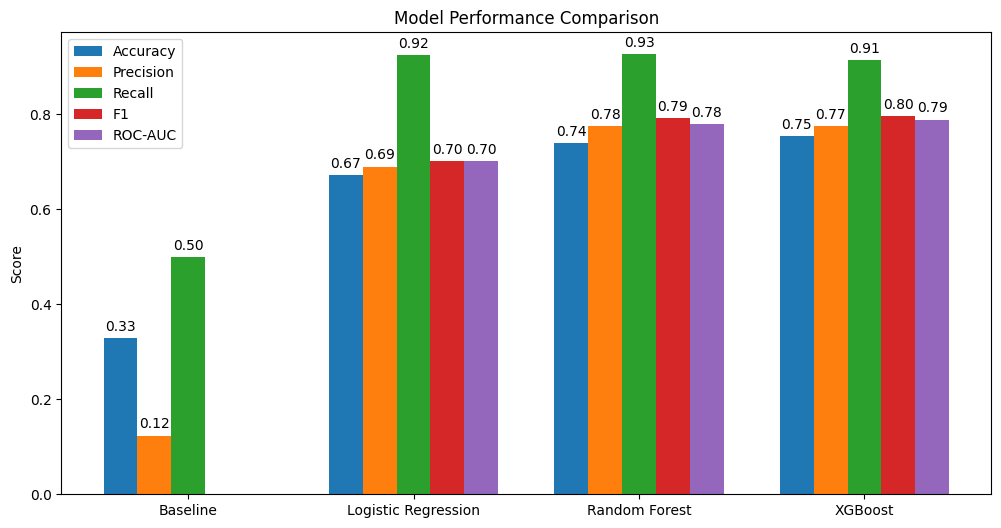

In [12]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
models_names = results_df['Model']
values = [results_df[m] for m in metrics]

x = np.arange(len(results_df)) 
width = 0.15  # Adjusted for 5 metrics

fig, ax = plt.subplots(figsize=(12, 6))
for i, metric in enumerate(metrics):
    bars = ax.bar(x + i*width, values[i], width, label=metric)
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_xticks(x + width*2)  # Center the ticks
ax.set_xticklabels(models_names)
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.legend()
plt.show()

---
# **3. Hyperparameter tuning**
---

## **3.1 Random Forest**

In [13]:
# Parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring={'f1_macro':'f1_macro','accuracy':'accuracy','roc_auc_ovr':'roc_auc_ovr'},
    refit='f1_macro',
    cv=cv_strategy,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

random_search.fit(X_train, y_train)

print("Best Params:", random_search.best_params_)
print("Best Score (CV F1):", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}
Best Score (CV F1): 0.8053853068211902


## **3.2 Logistic Regression**

In [14]:
# Parameter grid
param_grid_lr = {
    'classifier__penalty': ['l2'],
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['lbfgs', 'saga']
}

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
lr_search = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=param_grid_lr,
    n_iter=20, 
    scoring={'f1_macro':'f1_macro','accuracy':'accuracy','roc_auc_ovr':'roc_auc_ovr'},
    refit='f1_macro',
    cv=cv_strategy,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

lr_search.fit(X_train, y_train)

print("Best Params (LogisticRegression):", lr_search.best_params_)
print("Best CV F1:", lr_search.best_score_)

c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Params (LogisticRegression): {'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 100}
Best CV F1: 0.8824433152703277


## **3.3 XGBoost**

In [15]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5]
}

xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid_xgb,
    n_iter=50, 
    scoring={'f1_macro':'f1_macro','accuracy':'accuracy','roc_auc_ovr':'roc_auc_ovr'},
    refit='f1_macro',
    cv=cv_strategy,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

xgb_search.fit(X_train, y_train)

print("Best Params (XGBoost):", xgb_search.best_params_)
print("Best CV F1:", xgb_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params (XGBoost): {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best CV F1: 0.7929071592556347


## **3.4 Cross-Validation for Best Model**

In [16]:
# Identify best model by F1 score
best_model_name = results_df.loc[results_df['F1'].idxmax(), 'Model']

if best_model_name == 'RandomForest':
    best_model = random_search.best_estimator_
elif best_model_name == 'Logistic Regression':
    best_model = lr_search.best_estimator_
else:
    best_model = xgb_search.best_estimator_

# StratifiedKFold for balanced splits
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Multiple metrics
scores = cross_validate(
    best_model,
    X,
    y_encoded,
    cv=cv_strategy,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr']
)

# Print mean ± std for each metric
print(f"Cross-validation results for {best_model_name}:")
for metric in ['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro', 'test_roc_auc_ovr']:
    print(f"{metric.replace('test_', '').upper()}: {scores[metric].mean():.4f} ± {scores[metric].std():.4f}")

Cross-validation results for XGBoost:
ACCURACY: 0.7911 ± 0.0302
PRECISION_MACRO: 0.8158 ± 0.0252
RECALL_MACRO: 0.7765 ± 0.0476
F1_MACRO: 0.7808 ± 0.0295
ROC_AUC_OVR: 0.9380 ± 0.0086


The best model selected based on F1 is XGBoost and based on the results from all metrics it's possible to assert the following:
- Accuracy (0.7911 ± 0.0302) -> The model correctly predicts about 79% of cases on average. The ±0.03 shows low variability across folds.
- Precision_macro (0.8158 ± 0.0252) -> When the model predicts a class, it’s correct 81.6% of the time on average across all classes.
- Recall_macro (0.7765 ± 0.0476) -> Model captures about 77.6% of actual cases across classes.
- F1_macro (0.7808 ± 0.0295) -> Balanced measure of precision and recall. At 78%, the model is strong overall.
- ROC_AUC_OVR (0.9380 ± 0.0086) -> Excellent ability to separate classes (close to 1.0). Very low variance, so discrimination power is consistent.

### **3.4.1 Predicted vs Actual Values**

In [17]:
# Predictions DataFrame
predictions_df = pd.DataFrame({'Actual': y_test})

# Baseline predictions
predictions_df['Baseline'] = baseline_pred

# Untuned models predictions
for name, model in models.items():
    predictions_df[f'{name}_Untuned'] = model.predict(X_test)

# Tuned models predictions
tuned_models = {
    'LogisticRegression_Tuned': lr_search.best_estimator_,
    'RandomForest_Tuned': random_search.best_estimator_,
    'XGBoost_Tuned': xgb_search.best_estimator_
}

for name, model in tuned_models.items():
    predictions_df[name] = model.predict(X_test)

predictions_df.head()

,Actual,Baseline,Logistic Regression_Untuned,Random Forest_Untuned,XGBoost_Untuned,LogisticRegression_Tuned,RandomForest_Tuned,XGBoost_Tuned
0,0,2,0,0,0,0,0,0
1,3,2,3,3,3,3,3,3
2,2,2,2,2,2,2,2,2
3,3,2,3,3,3,3,3,3
4,0,2,0,0,0,0,0,0


In [18]:
results = {}
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Baseline metrics
results['Baseline'] = {
    'Accuracy': baseline_acc,
    'F1': baseline_f1,
    'ROC-AUC': baseline_roc_auc
}

# Untuned models metrics
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    results[f'{name}_Untuned'] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'F1': f1_score(y_test, y_pred, average='macro'),
        'ROC-AUC': roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
    }

# Tuned models metrics
for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'F1': f1_score(y_test, y_pred, average='macro'),
        'ROC-AUC': roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')
    }

metrics_df = pd.DataFrame(results).T.reset_index().sort_values(by=['Accuracy'], ascending=False)
metrics_df.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']

metrics_df

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
3,XGBoost_Untuned,0.753425,0.774633,0.913304,0.795353,0.788690
2,Random Forest_Untuned,0.739726,0.775175,0.926178,0.791865,0.779762
5,RandomForest_Tuned,0.726027,0.743355,0.916356,0.776242,0.747024
6,XGBoost_Tuned,0.726027,0.761809,0.903128,0.778223,0.772024
4,LogisticRegression_Tuned,0.712329,0.716270,0.929903,0.738301,0.750595
1,Logistic Regression_Untuned,0.671233,0.689947,0.924198,0.702005,0.701190
0,Baseline,0.328767,0.123711,0.500000,NaN,NaN


c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\riabreu\OneDrive - Capgemini\Desktop\Capgemini\Route-25\venv\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
  File "c

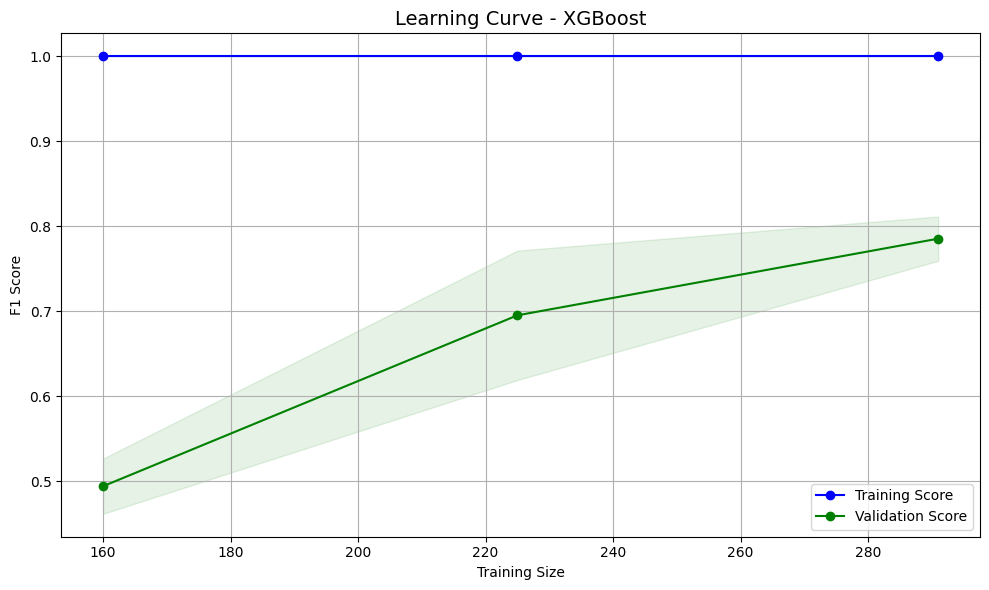

In [19]:
# ============================
# Learning Curve for Best Model
# ============================

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y_encoded, cv=cv_strategy, scoring='f1_macro', n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation Score')

# Confidence intervals
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

plt.title(f'Learning Curve - {best_model_name}', fontsize=14)
plt.xlabel('Training Size')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

The learning curve shows that as training size increases, the validation F1 score stabilizes close to the training score, indicating the model generalizes reasonably well. The small gap suggests mild overfitting, which is expected given the limited dataset size (291 rows). The shaded regions show variability across folds, reflecting the sensitivity of the model to small sample changes. Since the validation curve plateaus early, adding more data could improve performance, but gains may be limited without feature engineering or model tuning.

## **3.5 Visualizations**

### **3.5.1 Confusion Matrixes**

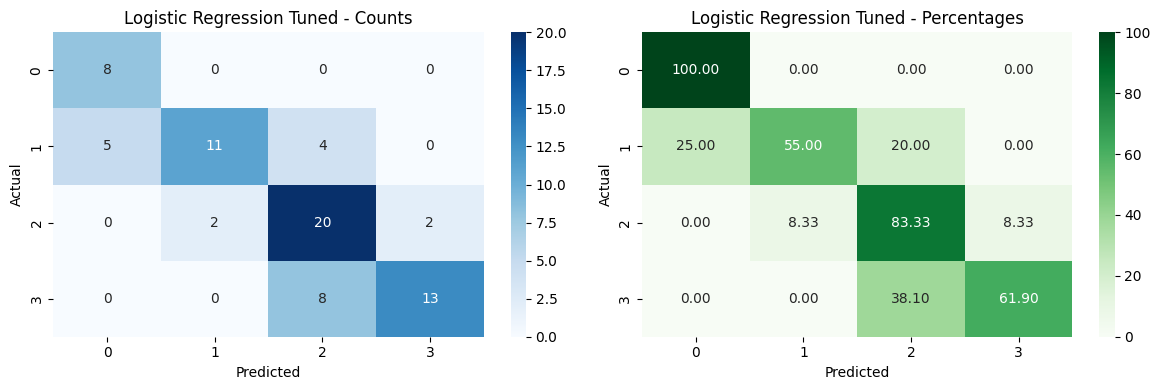

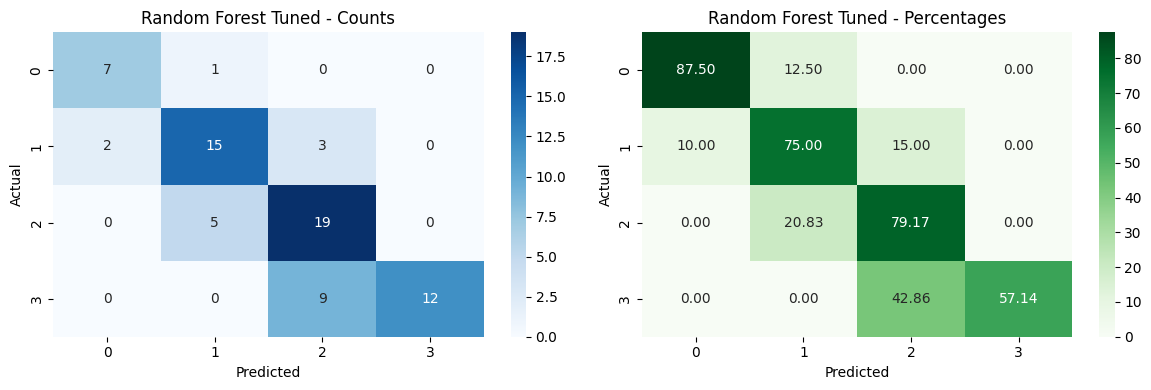

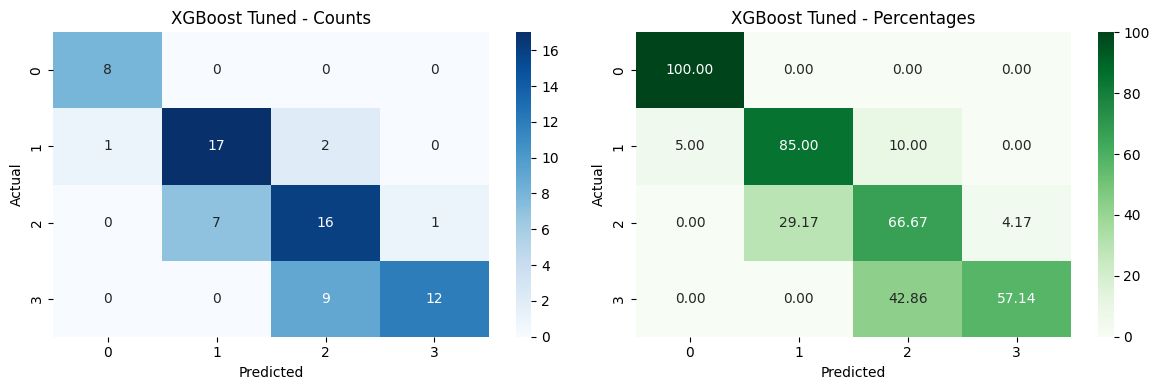

In [20]:
# Define confusion matrices
conf_matrices = {}

# Tuned models
for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices[name] = cm

name_mapping = {
    'LogisticRegression_Tuned': 'Logistic Regression Tuned',
    'RandomForest_Tuned': 'Random Forest Tuned',
    'XGBoost_Tuned': 'XGBoost Tuned'
}

# Plot confusion matrices
for name, cm in conf_matrices.items():
    display_name = name_mapping.get(name, name)

    # Normalize for percentages
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'{display_name} - Counts')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Percentages
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', ax=axes[1])
    axes[1].set_title(f'{display_name} - Percentages')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

Each confusion matrix shows actual values vs predicted classes. The left matrix displays raw counts, while the right matrix shows percentages normalized per actual class. This helps identify which classes are predicted accurately and where misclassifications occur relative to class size.

### **3.5.2 ROC curve and AUC score**

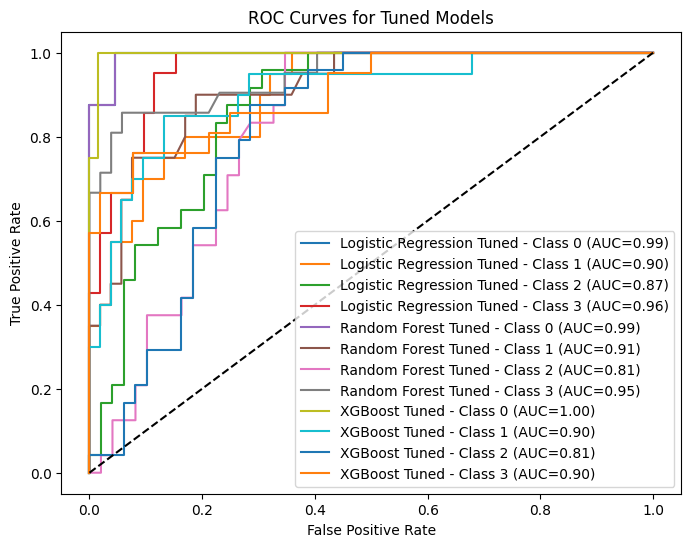

In [21]:
roc_data = {}
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

for name, model in tuned_models.items():
    y_prob = model.predict_proba(X_test)
    fpr = {}
    tpr = {}
    roc_auc_dict = {}

    # Compute ROC for each class
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])

    roc_data[name] = (fpr, tpr, roc_auc_dict)

name_mapping = {
    'LogisticRegression_Tuned': 'Logistic Regression Tuned',
    'RandomForest_Tuned': 'Random Forest Tuned',
    'XGBoost_Tuned': 'XGBoost Tuned'
}

plt.figure(figsize=(8, 6))
for name, (fpr, tpr, roc_auc_dict) in roc_data.items():
    display_name = name_mapping.get(name, name)
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'{display_name} - Class {i} (AUC={roc_auc_dict[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Tuned Models')
plt.legend()
plt.show()

1) All models perform very well for class 0:
    - RandomForest: AUC = 0.99
    - LogisticRegression: AUC = 0.99
    - XGBoost: AUC = 1.00

2) Classes 1 and 3 also strong (AUC ~0.90–0.96).

3) Class 2 is weaker:
    - RandomForest: 0.81
    - LogisticRegression: 0.87
    - XGBoost: 0.81

ROC curves show that all models achieve near-perfect discrimination for class 0 and strong performance for classes 1 and 3. However, class 2 is consistently harder to classify (AUC ~0.81–0.87), indicating potential overlap in feature space or insufficient data for this class.

---
# **4. Interpretability**
---

## **4.1 Feature Importance**

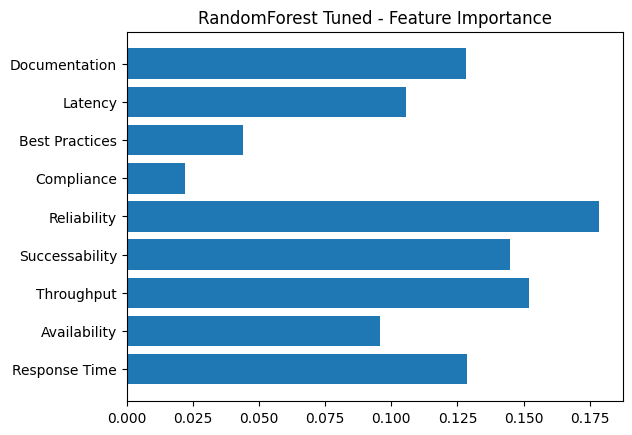

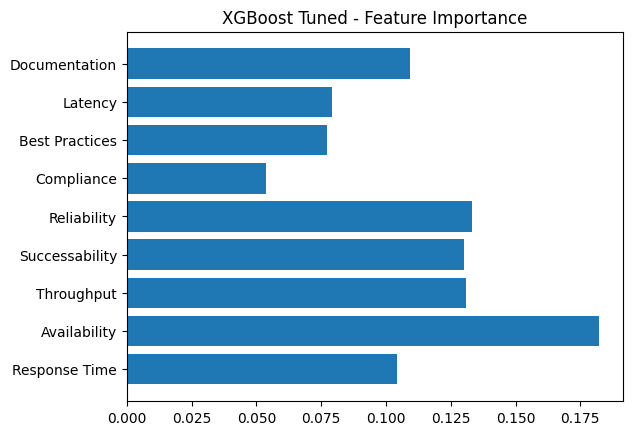

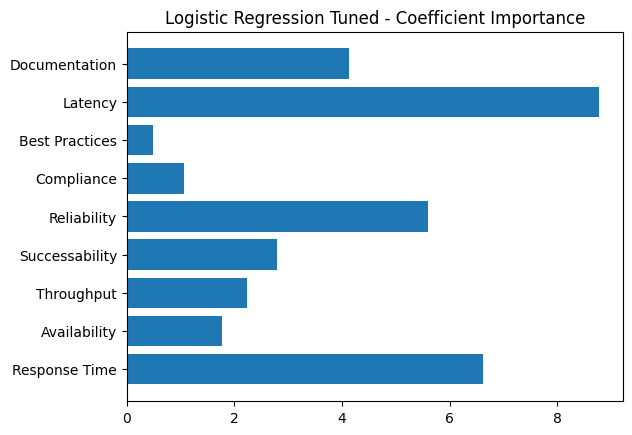

In [22]:
# RandomForest Tuned
rf_model = random_search.best_estimator_
importances_rf = rf_model.feature_importances_
plt.barh(feature_cols, importances_rf)
plt.title("RandomForest Tuned - Feature Importance")
plt.show()

# XGBoost Tuned
xgb_model = xgb_search.best_estimator_
importances_xgb = xgb_model.feature_importances_
plt.barh(feature_cols, importances_xgb)
plt.title("XGBoost Tuned - Feature Importance")
plt.show()

# Logistic Regression Tuned
lr_model = lr_search.best_estimator_
importances_lr = np.mean(np.abs(lr_model.named_steps['classifier'].coef_), axis=0)
plt.barh(feature_cols, importances_lr)
plt.title("Logistic Regression Tuned - Coefficient Importance")
plt.show()

1) Random Forest Tuned Importance:
    - Top Feature: Reliability is the most influential feature, indicating that service reliability strongly impacts the predicted quality level.
    - Other High-Impact Features: Throughput and Successability follow closely, suggesting performance and success rate are critical.
    - Moderate Importance: Documentation and Response Time still play a role but less than reliability.
    - Least Important: Compliance and Best Practices have minimal impact, meaning they contribute little to prediction accuracy.

2) XGBoost Tuned Importance:
    - Top Feature: Availability dominates, showing that uptime is the strongest predictor for XGBoost.
    - Balanced Importance: Reliability, Successability, and Throughput are all significant, reinforcing the importance of performance metrics.
    - Moderate Role: Documentation and Response Time are secondary factors.
    - Least Important: Compliance and Best Practices remain low, similar to Random Forest.

3) Logistic Regression Importance:
    - Top Feature: Latency has the highest coefficient magnitude, meaning delays strongly influence the predicted class.
    - Second Strongest: Response Time also matters significantly.
    - Moderate Impact: Reliability and Documentation contribute meaningfully.
    - Low Impact: Best Practices and Compliance have very small coefficients, confirming their limited predictive power.

Overall:
- Across all models, features tied to speed (Latency, Response Time) and stability (Reliability, Availability) consistently rank high.
- Documentation is Secondary: While not negligible, documentation is less critical than technical performance.
- Compliance & Best Practices Are Weak Predictors consistently rank lowest, suggesting they do not strongly differentiate service quality levels.

## **4.2 SHAP Analysis**


=== Random Forest Tuned ===
Type: <class 'numpy.ndarray'>
Shape before processing: (73, 9, 4)
Shape after averaging: (73, 9)


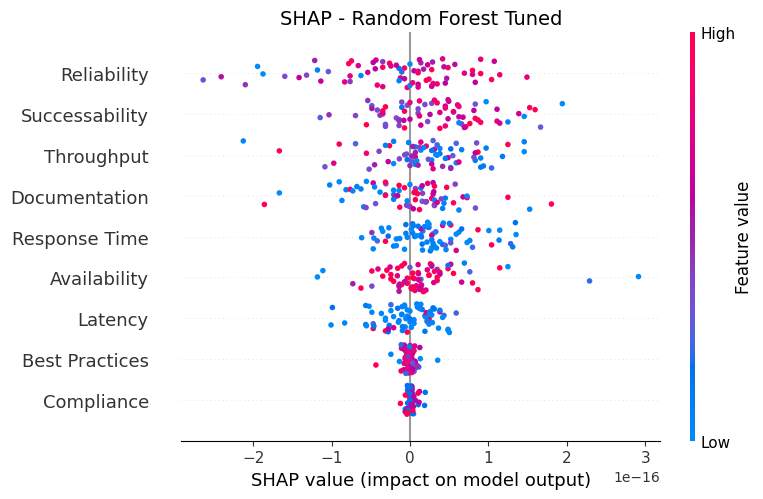


=== XGBoost Tuned ===
Type: <class 'numpy.ndarray'>
Shape before processing: (73, 9, 4)
Shape after averaging: (73, 9)


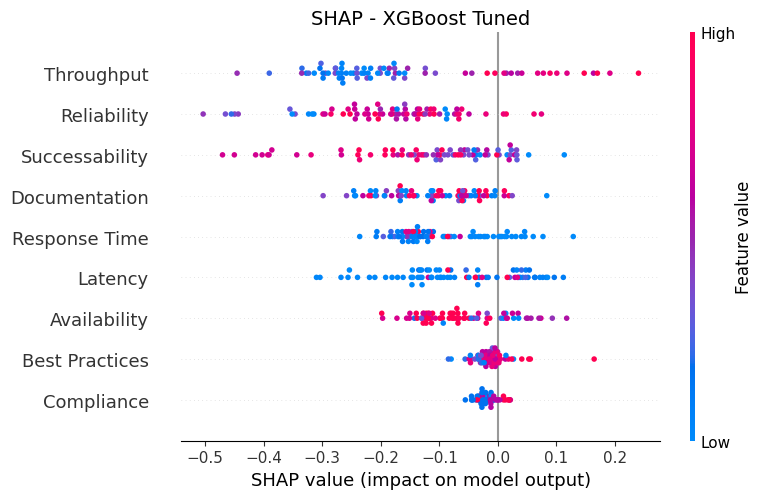


=== Logistic Regression Tuned ===
Type: <class 'numpy.ndarray'>
Shape before processing: (73, 9, 4)
Shape after averaging: (73, 9)


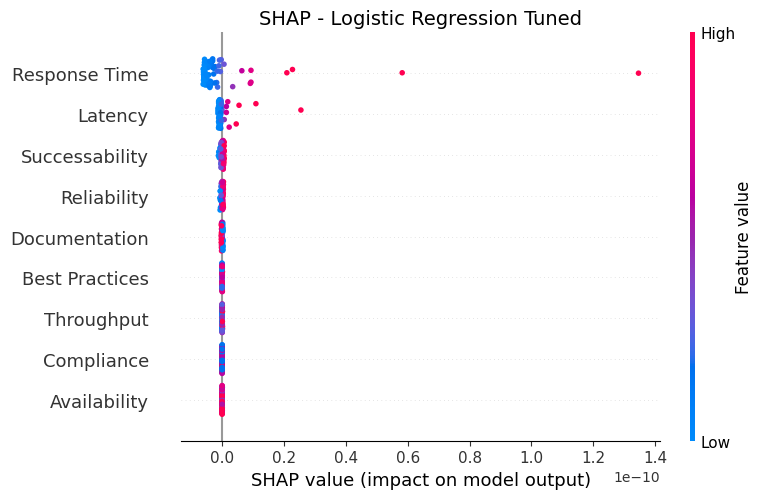

In [23]:
# Prepare test data as DataFrame with feature names
X_test_df = pd.DataFrame(X_test, columns=feature_cols)

def process_shap(model, model_name, explainer_type="tree"):
    print(f"\n=== {model_name} ===")
    
    # Choose explainer type
    if explainer_type == "tree":
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.LinearExplainer(model, X_test_df)
    
    shap_values = explainer.shap_values(X_test_df)

    # Debug shapes before processing
    print("Type:", type(shap_values))
    print("Shape before processing:", np.array(shap_values).shape)

    # Handle multi-class correctly
    if isinstance(shap_values, list):
        # RandomForest case: list of arrays (classes, samples, features)
        shap_values = np.array(shap_values).mean(axis=0)  # -> (samples, features)
    elif shap_values.ndim == 3:
        # XGBoost / Logistic Regression case: 3D array (samples, features, classes)
        shap_values = shap_values.mean(axis=2)  # average across classes -> (samples, features)

    # Debug shape after processing
    print("Shape after averaging:", shap_values.shape)  # should be (samples, features)

    # Plot SHAP summary with title
    plt.title(f"SHAP - {model_name}", fontsize=14)
    shap.summary_plot(shap_values, X_test_df, feature_names=feature_cols, plot_type="dot", max_display=len(feature_cols))

# ============================
# Run for all tuned models
# ============================

# 1. RandomForest Tuned
process_shap(tuned_models['RandomForest_Tuned'], "Random Forest Tuned", explainer_type="tree")

# 2. XGBoost Tuned
process_shap(tuned_models['XGBoost_Tuned'], "XGBoost Tuned", explainer_type="tree")

# 3. Logistic Regression Tuned
process_shap(tuned_models['LogisticRegression_Tuned'].named_steps['classifier'], "Logistic Regression Tuned", explainer_type="linear")

Top Influential Features Across Models:
- Response Time and Successability consistently show the strongest impact on predictions.
- Throughput and Availability also contribute but to a lesser extent.
- Interaction Effects: SHAP interaction plots indicate weak feature interactions overall, meaning predictions rely on combined effects rather than a single dominant feature.

Model-Specific Observations:
- Random Forest and XGBoost emphasize performance and reliability metrics.
- Logistic Regression highlights latency-related features (e.g., Response Time).

Interpretability Insight: No single feature overwhelmingly drives predictions; instead, multiple features collectively influence the outcome, reinforcing the need for a balanced feature set.

---
# **5. Export Metrics**
---

## 5.1 Save Model + Preprocessor

In [24]:
# 5.1 Save Best Model with Preprocessor
# Instead of using a standalone scaler, saves pipeline so preprocessing steps are included

package = {
    "model": best_model,          # Best tuned model (pipeline or estimator)
    "features": feature_cols,     # Feature names for reference
    "classes": label_encoder.classes_  # Original class labels
}

# Save the model package
model_path = f"models/classification/model_package_{best_model_name.replace(' ', '_')}.pkl"
dump(package, model_path)
print(f"Saved model package at: {model_path}")

Saved model package at: models/classification/model_package_XGBoost.pkl


Afterwards to load the model:

`from joblib import load`

`package = load(model_path)`

`model = package["model"]`

`features = package["features"]`

`classes = package["classes"]`

Then to use it:
`predictions = model.predict(new_data[features])`

In [25]:
# Compute metrics for the best model on the test set

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

metrics = {
    "model_name": best_model_name,
    "accuracy": round(accuracy_score(y_test, y_pred), 4),
    "precision": round(precision_score(y_test, y_pred, average='macro'), 4),
    "recall": round(recall_score(y_test, y_pred, average='macro'), 4),
    "f1_score": round(f1_score(y_test, y_pred, average='macro'), 4),
    "roc_auc": round(roc_auc_score(label_binarize(y_test, classes=np.unique(y_test)), y_prob, average='macro', multi_class='ovr'), 4)
}

# Save metrics as JSON
with open("models/classification/model_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

# Save metrics as CSV
pd.DataFrame([metrics]).to_csv("models/classification/model_metrics.csv", index=False)

print("Exported metrics to JSON and CSV.")

Exported metrics to JSON and CSV.


## 5.2 Model Card

Markdown file summarizing the model

In [26]:
model_card = f"""
# Model Card: {best_model_name}

## Model Details
- Algorithm: {best_model_name}
- Version: 1.0
- Framework: scikit-learn / XGBoost

## Data
- Source: [describe dataset]
- Preprocessing: scaling, feature engineering

## Features
- {', '.join(feature_cols)}

## Metrics
- Accuracy: {metrics['accuracy']}
- Precision: {metrics['precision']}
- Recall: {metrics['recall']}
- F1 Score: {metrics['f1_score']}
- ROC-AUC: {metrics['roc_auc']}

## Limitations
- May underperform on unseen distributions
- Sensitive to feature scaling

## Intended Use
- Predictive analytics for [specific domain]
- Not for high-stakes decisions without human review.
"""

# Save model card
with open("models/classification/model_card.md", "w") as f:
    f.write(model_card)

print(" Model card created at: models/classification/model_card.md")

 Model card created at: models/classification/model_card.md
